# Проект Прогнозирование количества заказов такси

### Импорт необходимых библиотек

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from math import sqrt

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import StandardScaler 


### Установка необходимых пакетов

In [1]:
try:
    %pip install pyramid
    %pip install pyramid-arima
    from pyramid.arima import auto_arima
except:
    %pip inslall pmdarima
    from pmdarima.arima import auto_arima

### Цель проекта:

Необходимо построить модель прогнозирования количество заказов такси на следующий час.  
Значение метрики RMSE на тестовой выборке по полученной модели не должно превышать 48.

### Описание данных

Количество заказов находится в столбце `num_orders`

## Содержание проекта

[1. Загрузка и подготовка данных](#1)  
[2. Анализ даных](#2)  
[3. Обучение моделей](#3)  
[4. Проверка модели](#4)  
[Общий вывод](#itog)  

# 1. Загрузка и подготовка данных <a id="1"></a>

In [4]:
taxi.index

DatetimeIndex(['2018-03-01 00:00:00', '2018-03-01 00:10:00',
               '2018-03-01 00:20:00', '2018-03-01 00:30:00',
               '2018-03-01 00:40:00', '2018-03-01 00:50:00',
               '2018-03-01 01:00:00', '2018-03-01 01:10:00',
               '2018-03-01 01:20:00', '2018-03-01 01:30:00',
               ...
               '2018-08-31 22:20:00', '2018-08-31 22:30:00',
               '2018-08-31 22:40:00', '2018-08-31 22:50:00',
               '2018-08-31 23:00:00', '2018-08-31 23:10:00',
               '2018-08-31 23:20:00', '2018-08-31 23:30:00',
               '2018-08-31 23:40:00', '2018-08-31 23:50:00'],
              dtype='datetime64[ns]', name='datetime', length=26496, freq=None)

In [5]:
display(taxi.info())
display(taxi.describe())
display(taxi.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выполним ресэмплинг

In [6]:
taxi_H = taxi.resample('1H').sum()
taxi_D = taxi.resample('1D').sum()


## Вывод

Проведена загрузка данных и выполнен ресэмплинг.

# 2. Анализ данных <a id="2"></a>

Визуально оценим график нашего временного ряда.

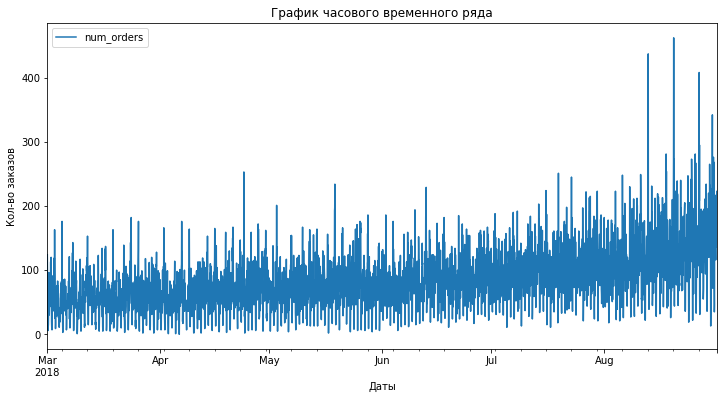

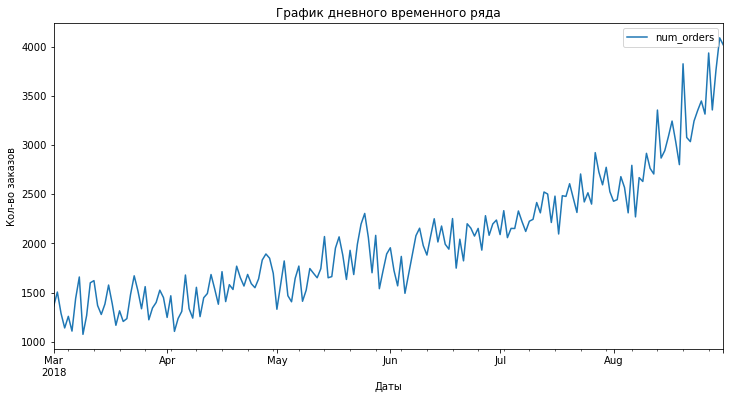

In [7]:
taxi_H.plot(figsize=(12,6))
plt.title('График часового временного ряда')
plt.xlabel('Даты')
plt.ylabel('Кол-во заказов')

taxi_D.plot(figsize=(12,6))
plt.title('График дневного временного ряда')
plt.xlabel('Даты')
plt.ylabel('Кол-во заказов')
plt.show()

Видно, что график имеет ярко выраженный тренд, что говорит о его нестационарности.

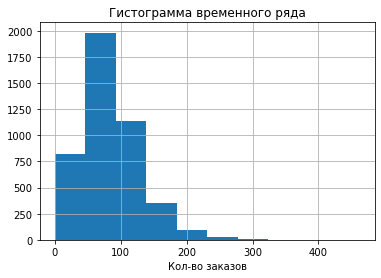

In [8]:
taxi_H.hist()
plt.title('Гистограмма временного ряда')
plt.xlabel('Кол-во заказов')
plt.show()

Расчитаем коэффициент вариации по формуле:

$$V = \frac{\sigma}{\overline{x}}$$   

Если коэффициент вариации больше  33 %, это, согласно классической теории, говорит о неоднородности ряда, т.е. большом разбросе данных относительно среднего значения.

In [9]:
taxi_H.std()/taxi_H.mean()


num_orders    0.533314
dtype: float64

Коэффициент вариации равен 53.3 , что говорит о неоднородности временного ряда, об этом же косвенно можно судить и по гистограмме. 

Разложим временной ряд на тренд и сезонную компоненту

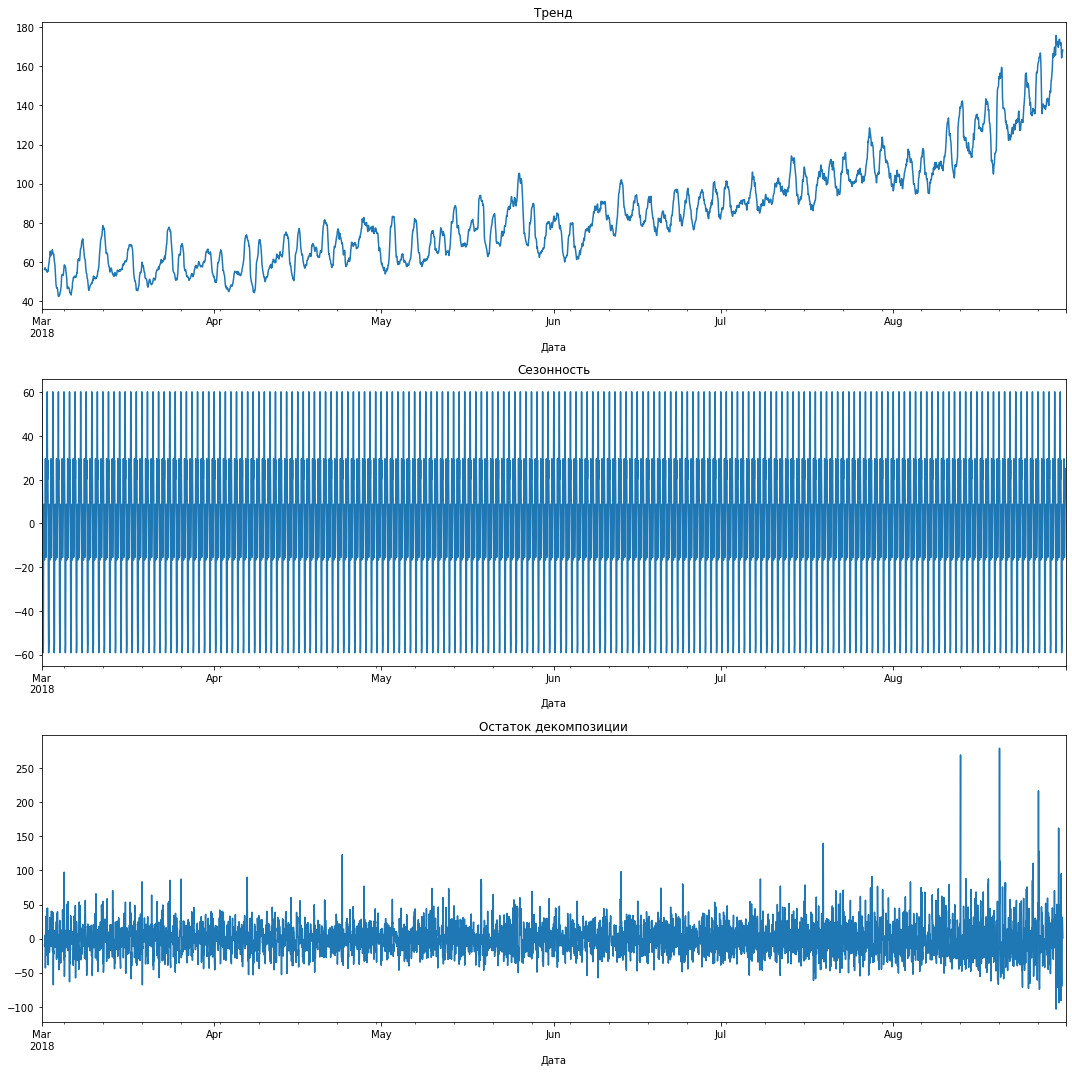

In [10]:
decomposed = seasonal_decompose(taxi_H) 

plt.figure(figsize=(15, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.xlabel('Дата')
plt.tight_layout()

Рассмотрим сезонность более подробно:

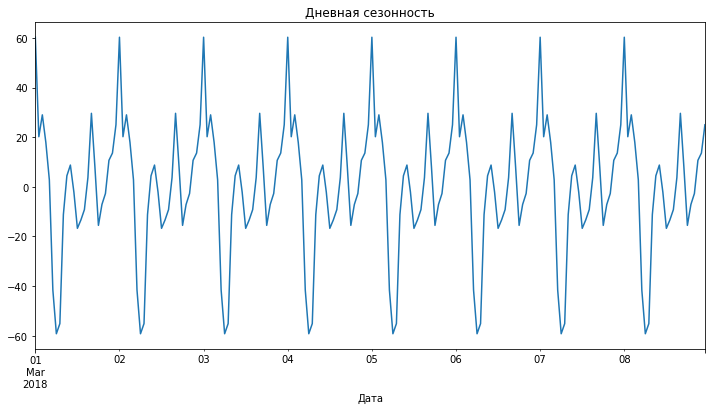

In [11]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(12, 6))
decomposed.seasonal['2018-03-01':'2018-03-08'].plot(ax=plt.gca())
plt.title('Дневная сезонность')
plt.xlabel('Дата')
plt.subplot()
plt.show()


Видим, что мы имеем внутридневную сезонность.


Найдем разности временного ряда. Если первые разности ряда стационарны, то ряд называется интегрированным рядом первого порядка.

На графике ниже можем видеть,  что тренд отсутствует, т.о. можем сделать вывод о стационарности ряда первых разностей и наш исходный ряд, вероятно,  является интегрированным рядом первого порядка. 

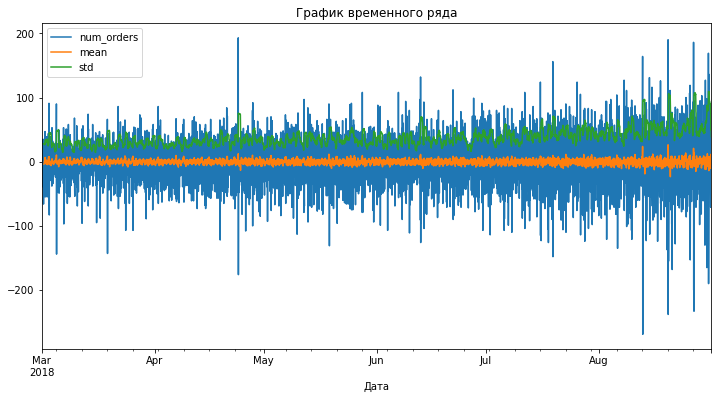

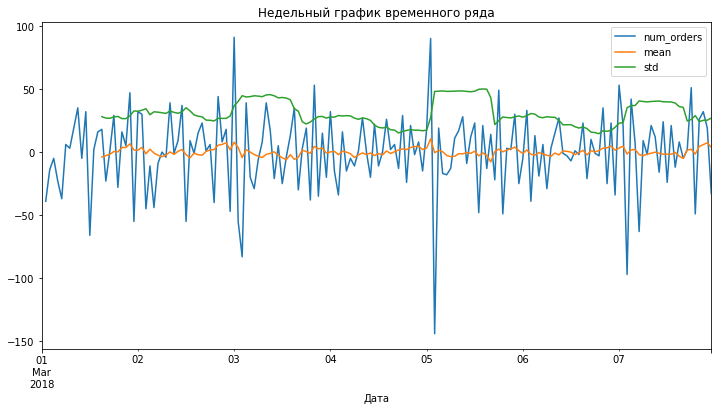

In [12]:
taxi_shift = taxi_H - taxi_H.shift()
taxi_shift['mean'] = taxi_shift['num_orders'].rolling(15).mean()
taxi_shift['std'] = taxi_shift['num_orders'].rolling(15).std()
taxi_shift.plot(figsize=(12,6))
plt.title('График временного ряда')
plt.xlabel('Дата')
taxi_shift['2018-03-01':'2018-03-07'].plot(figsize=(12,6))
plt.title('Недельный график временного ряда')
plt.xlabel('Дата')
plt.show()

# Вывод

Проведен анализ исходного ряда. Установлено, что ряд является нестационарным и неоднородным.  
Бало проведено дополнительное исследование разности временного ряда, было высказано предположение, что исходный ряд является интегрированным рядом первого порядка.  


# 3. Обучение моделей <a id="3"></a>

Создание признаков:

In [13]:
def make_features(taxi_H, max_lag, rolling_mean_size):
    #taxi_H['year'] = taxi.index.year
    taxi_H['month'] = taxi_H.index.month
    taxi_H['day'] = taxi_H.index.day
    taxi_H['dayofweek'] = taxi_H.index.dayofweek
    taxi_H['hour'] = taxi_H.index.hour
    
    for lag in range(1, max_lag + 1):
        taxi_H['lag_{}'.format(lag)] = taxi_H['num_orders'].shift(lag)

    taxi_H['rolling_mean'] = taxi_H['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(taxi_H, 50, 20)


Разбиение на выборки:

In [14]:
train, test = train_test_split(taxi_H, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-03 02:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [15]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [16]:
features_train.head()

,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,3,3,5,2,108.0,163.0,72.0,119.0,101.0,93.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,69.85
2018-03-03 03:00:00,3,3,5,3,25.0,108.0,163.0,72.0,119.0,101.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,70.55
2018-03-03 04:00:00,3,3,5,4,64.0,25.0,108.0,163.0,72.0,119.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,73.40
2018-03-03 05:00:00,3,3,5,5,44.0,64.0,25.0,108.0,163.0,72.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,73.30
2018-03-03 06:00:00,3,3,5,6,15.0,44.0,64.0,25.0,108.0,163.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,71.80


In [17]:
target_train.head()

datetime
2018-03-03 02:00:00    25
2018-03-03 03:00:00    64
2018-03-03 04:00:00    44
2018-03-03 05:00:00    15
2018-03-03 06:00:00     9
Freq: H, Name: num_orders, dtype: int64

In [18]:
features_test.head()

,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,8,13,0,14,119.0,92.0,144.0,156.0,137.0,91.0,...,84.0,102.0,62.0,122.0,174.0,143.0,73.0,53.0,63.0,140.20
2018-08-13 15:00:00,8,13,0,15,102.0,119.0,92.0,144.0,156.0,137.0,...,105.0,84.0,102.0,62.0,122.0,174.0,143.0,73.0,53.0,141.40
2018-08-13 16:00:00,8,13,0,16,175.0,102.0,119.0,92.0,144.0,156.0,...,89.0,105.0,84.0,102.0,62.0,122.0,174.0,143.0,73.0,146.05
2018-08-13 17:00:00,8,13,0,17,144.0,175.0,102.0,119.0,92.0,144.0,...,155.0,89.0,105.0,84.0,102.0,62.0,122.0,174.0,143.0,148.35
2018-08-13 18:00:00,8,13,0,18,152.0,144.0,175.0,102.0,119.0,92.0,...,174.0,155.0,89.0,105.0,84.0,102.0,62.0,122.0,174.0,149.20


In [19]:
target_test.head()

datetime
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
Freq: H, Name: num_orders, dtype: int64

Обучим несколько моделей:

# LinearRegression

In [20]:
model = LinearRegression()
mse = pd.Series(cross_val_score(model, features_train, target_train, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=5).split(features_train))).min()
print('RMSE', sqrt(-mse))

model.fit(features_train, target_train)
predict = model.predict(features_train)


RMSE 31.214415198875496


Визуально оценим результат моделирования:

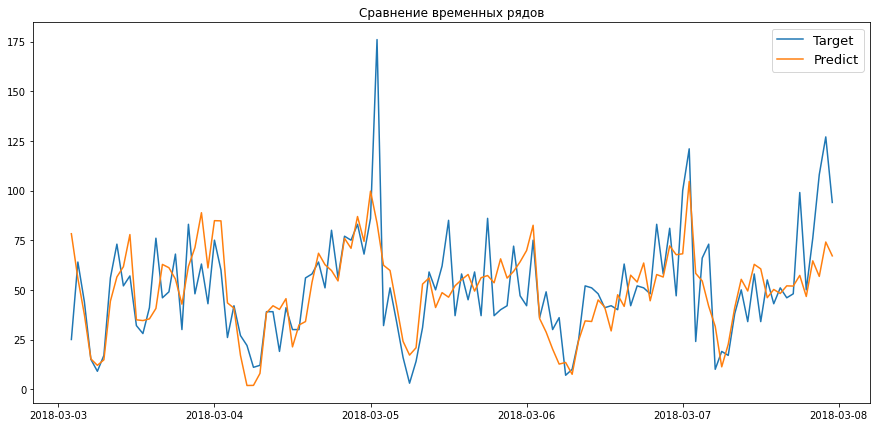

In [21]:
LinReg = pd.DataFrame()
LinReg['predict'] = pd.Series(predict)

LinReg.index = train.index
LinReg['target'] = train['num_orders']

plt.figure(figsize=(15, 7))
plt.plot(LinReg['target']['2018-03-01':'2018-03-07'], label = "Target")
plt.plot(LinReg['predict']['2018-03-01':'2018-03-07'], label = "Predict")
plt.legend(loc="best", fontsize=13)
plt.title('Сравнение временных рядов')
plt.show()


# RandomForestRegressor

In [22]:
%%time
model = RandomForestRegressor(random_state = 12345)
parameters = {'n_estimators': range(18, 19), 'max_depth': range(6, 7)} # уже оптимизированы, для экономии времени расчета
grid = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=5).split(features_train))
grid.fit(features_train, target_train)

print('Оптимальные параметры модели:', grid.best_params_)
mse = grid.best_score_
print('RMSE', sqrt(-mse)) 

model = RandomForestRegressor(random_state = 1234, max_depth=6, n_estimators=18)
model.fit(features_train, target_train)
predict = model.predict(features_train)


Оптимальные параметры модели: {'max_depth': 6, 'n_estimators': 18}
RMSE 26.089912671879567
CPU times: user 6.31 s, sys: 5.36 ms, total: 6.32 s
Wall time: 6.32 s


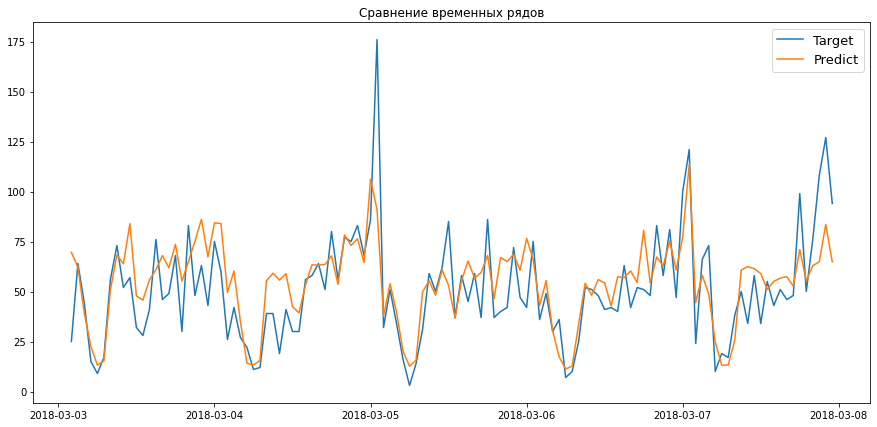

In [23]:
RandForest = pd.DataFrame()
RandForest['predict'] = pd.Series(predict)

RandForest.index = train.index
RandForest['target'] = train['num_orders']

plt.figure(figsize=(15, 7))
plt.plot(RandForest['target']['2018-03-01':'2018-03-07'], label = "Target")
plt.plot(RandForest['predict']['2018-03-01':'2018-03-07'], label = "Predict")
plt.legend(loc="best", fontsize=13)
plt.title('Сравнение временных рядов')
plt.show()


# XGBoost

In [24]:

model = XGBRegressor(random_state = 12345)
parameters = {'n_estimators': range(29, 30), 'max_depth': range(2, 3)} # уже оптимизированы, для экономии времени расчета
grid = GridSearchCV(model, parameters, scoring = 'neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=5).split(features_train))
grid.fit(features_train, target_train)

print('Оптимальные параметры модели:', grid.best_params_)
mse = grid.best_score_
print('RMSE', sqrt(-mse))

model = XGBRegressor(random_state = 1234, max_depth=2, n_estimators=29)
model.fit(features_train, target_train)
predict = model.predict(features_train)


Оптимальные параметры модели: {'max_depth': 2, 'n_estimators': 29}
RMSE 25.21569128193588


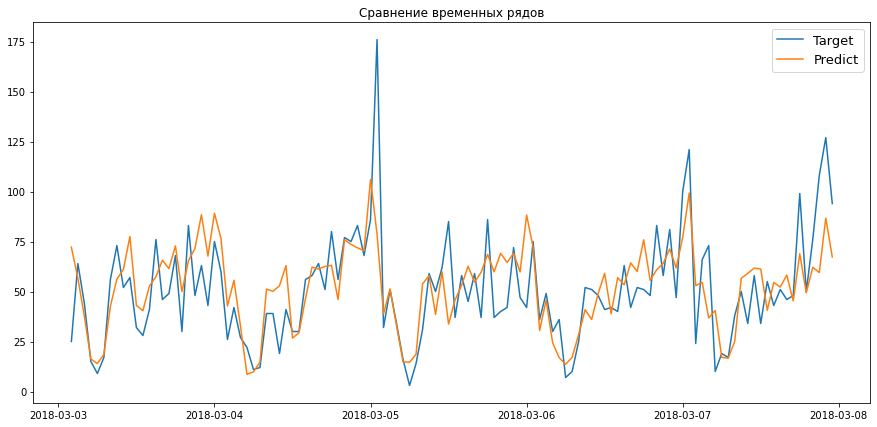

In [25]:
XGB = pd.DataFrame()
XGB['predict'] = pd.Series(predict)

XGB.index = train.index
XGB['target'] = train['num_orders']

plt.figure(figsize=(15, 7))
plt.plot(XGB['target']['2018-03-01':'2018-03-07'], label = "Target")
plt.plot(XGB['predict']['2018-03-01':'2018-03-07'], label = "Predict")
plt.legend(loc="best", fontsize=13)
plt.title('Сравнение временных рядов')
plt.show()


Судя по графикам для всех моделей, модель удовлетворительно описала исходный временной ряд, уловив дневную сезонность, но не смогла поймать  всплески заказов.   
Значение метрики практически идентично для RandomForest и XGBoost.

# ARIMA

Подготовим данные для модели.

In [26]:
#preprocessing (так как arima принимает на вход только одномерные ряды)
train_arima, valid_arima = train_test_split(train, shuffle=False, test_size=0.2)
train_arima = train_arima['num_orders']
valid_arima = valid_arima['num_orders']
test_arima = test['num_orders']

In [27]:
train_arima

datetime
2018-03-03 02:00:00     25
2018-03-03 03:00:00     64
2018-03-03 04:00:00     44
2018-03-03 05:00:00     15
2018-03-03 06:00:00      9
                      ... 
2018-07-11 16:00:00     76
2018-07-11 17:00:00    184
2018-07-11 18:00:00     80
2018-07-11 19:00:00     76
2018-07-11 20:00:00     92
Freq: H, Name: num_orders, Length: 3139, dtype: int64

In [28]:
valid_arima

datetime
2018-07-11 21:00:00     94
2018-07-11 22:00:00     93
2018-07-11 23:00:00     96
2018-07-12 00:00:00    129
2018-07-12 01:00:00    145
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 785, dtype: int64

Построим график наших данных

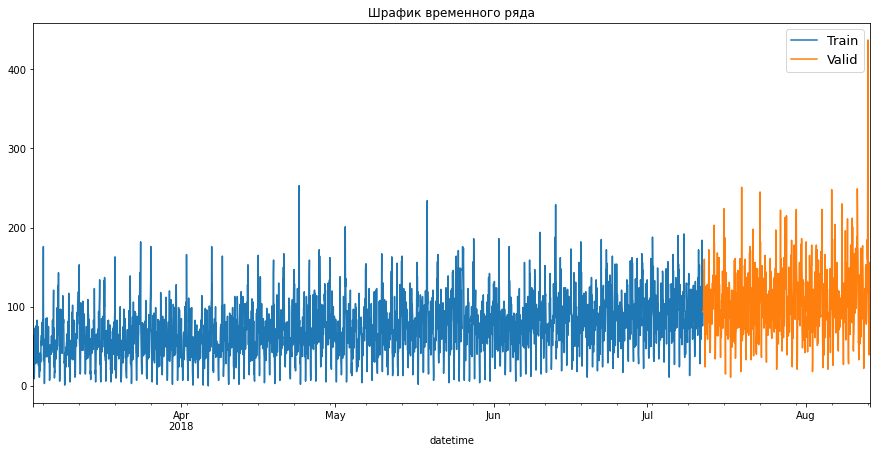

In [29]:
plt.figure(figsize=(15, 7))
train_arima.plot(label = "Train")
valid_arima.plot(label = "Valid")

plt.legend(loc="best", fontsize=13)
plt.title('Шрафик временного ряда')
plt.show()

Строим модель

In [30]:
%%time
#from pyramid.arima import auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(train_arima, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_arima)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=8.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30920.791, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30615.577, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30488.381, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30918.792, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.47 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=30486.385, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=1.19 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30613.578, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=1.80 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 35.784 seconds
CPU times: user 36.1 s, sys: 135 ms, total: 36.2 s

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [31]:
predict = model.predict(n_periods=len(valid_arima))
predict = pd.DataFrame(predict,index = valid_arima.index,columns=['Prediction'])

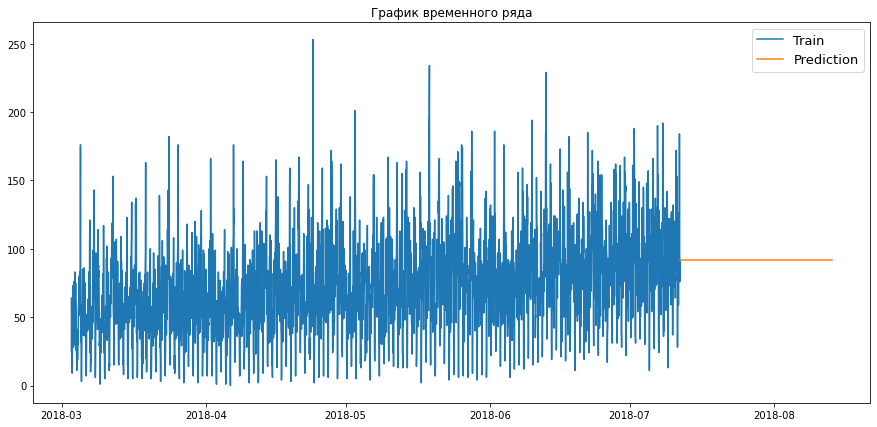

In [32]:
plt.figure(figsize=(15, 7))
plt.plot(train_arima, label='Train')
plt.plot(predict, label='Prediction')
plt.legend(loc="best", fontsize=13)
plt.title('График временного ряда')
plt.show()

In [33]:
rmse = sqrt(mean_squared_error(valid_arima,predict))
print('RMSE', rmse)


RMSE 44.98832116468304


ARIMA показывает несколько худшие результаты, по сравнению с предыдущими моделями.

# Вывод

Были исследованы  4 модели для прогнозирования исходного временного ряда.  
Лучшие результаты, со значением целевой метрики, равной 26, показали RandomForest и XGBoost.  
Дальнейшее тестирование проведем на базе модели XGB.

# 4. Проверка модели <a id="4"></a>

## XGB

RMSE 42.55612747910231


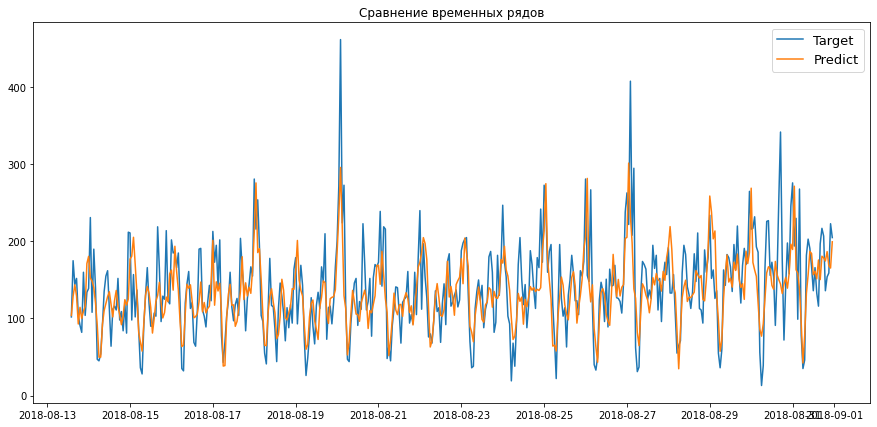

In [34]:
model = XGBRegressor(random_state = 1234, max_depth=2, n_estimators=29)
model.fit(features_train, target_train)
predict = model.predict(features_test)
mse = mean_squared_error(target_test, predict)
print('RMSE', sqrt(mse))

XGB = pd.DataFrame()
XGB['predict'] = pd.Series(predict)

XGB.index = test.index
XGB['target'] = test['num_orders']

plt.figure(figsize=(15, 7))
plt.plot(XGB['target'], label = "Target")
plt.plot(XGB['predict'], label = "Predict")
plt.legend(loc="best", fontsize=13)
plt.title('Сравнение временных рядов')
plt.show()


# Общий вывод <a id="itog"></a>

В процессе выполнения проекта:
    - исследован исходный временной ряд сервиса по вызову такси.   
    - апробированы различные модели прогнозирования временного ряда количества вызовов сервиса такси.    
Были выбраны модели, обеспечивающие минимальное значение искомой метрики, удовлетворяющее требованиям задачи.  
Итоговая модель на базе XGB обеспечивает значение метрики RMSE на уровне 42 единиц.
